In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=300)

In [2]:
df = pd.read_json("train.json")

#Create dataframes bsaed on interest levels
df_low      = df.drop(df[df.interest_level != "low"].index)
df_medium   = df.drop(df[df.interest_level != "medium"].index)
df_high     = df.drop(df[df.interest_level != "high"].index)

In [3]:
df.head(3)
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


# Data Preprocessing and Feature Engineering

In [4]:
# cut data by 1st and 99th percentile
def price_percent_cut(df_NEW, col):
    price_low = np.percentile(df_NEW[col].values, 1)
    price_high = np.percentile(df_NEW[col].values, 99)
    
    df_NEW = df_NEW.drop(df_NEW[df_NEW.col < price_low].index)
    df_NEW = df_NEW.drop(df_NEW[df_NEW.col > price_high].index)
    
    return df_NEW


# Datetime object and number of photos feature engineering
def clean_preprocess(initial_df):
    # convert created column into datetime type
    try:        
        initial_df['DateTime'] = pd.to_datetime(initial_df.created)
        initial_df.drop('created', axis=1, inplace=True)

        # create feature for number of photos
        initial_df['num_of_photos'] = initial_df.photos.map(len)
    except:
        print("Clean_Preprocessed function skipped as it can only be run once")
    return initial_df


# Remove prices outside of defined range
def remove_outlier_prices(df_NEW):    
    df_NEW = df_NEW.drop(df_NEW[df_NEW.price < price_low].index)
    df_NEW = df_NEW.drop(df_NEW[df_NEW.price > price_high].index)    
    return df_NEW

# Remove locations outside of New York
def remove_nonNY_coords(df_NEW):    
    #Removing out of bounds longitude
    df_NEW = df_NEW.drop(df_NEW[df_NEW.longitude < long_low].index)
    df_NEW = df_NEW.drop(df_NEW[df_NEW.longitude > long_high].index)

    #Removing out of bounds latitude
    df_NEW = df_NEW.drop(df_NEW[df_NEW.latitude < lat_low].index)
    df_NEW = df_NEW.drop(df_NEW[df_NEW.latitude > lat_high].index)

    return df_NEW

df = pd.read_json("train.json")

#Price limits
price_low = 1000
#price_high = 10000
#price_low = np.percentile(df['price'].values, 0.5)
price_high = np.percentile(df['price'].values, 99)

# Define upper and lower limits for NewYork
long_low  = -74.1
long_high = -73.6
lat_low   =  35
lat_high  =  41

# Run it
This cell calls the above functions and show how many rows of data are removed at each step

In [5]:
dataCount = len(df)
print(dataCount,"datapoints in dataset")

df = clean_preprocess(df)
newCount= len(df)
print("cleanPreprocess removed",dataCount-newCount,"datapoints")
dataCount=newCount

df = remove_nonNY_coords(df)
newCount= len(df)
print("remove_nonNY_coords removed",dataCount-newCount,"datapoints")
dataCount=newCount

df = remove_outlier_prices(df)
newCount= len(df)
print("remove_outlier_prices removed",dataCount-newCount,"datapoints")

print(newCount, "datapoints remaining")

49352 datapoints in dataset
cleanPreprocess removed 0 datapoints
remove_nonNY_coords removed 60 datapoints
remove_outlier_prices removed 491 datapoints
48801 datapoints remaining


# Plotting

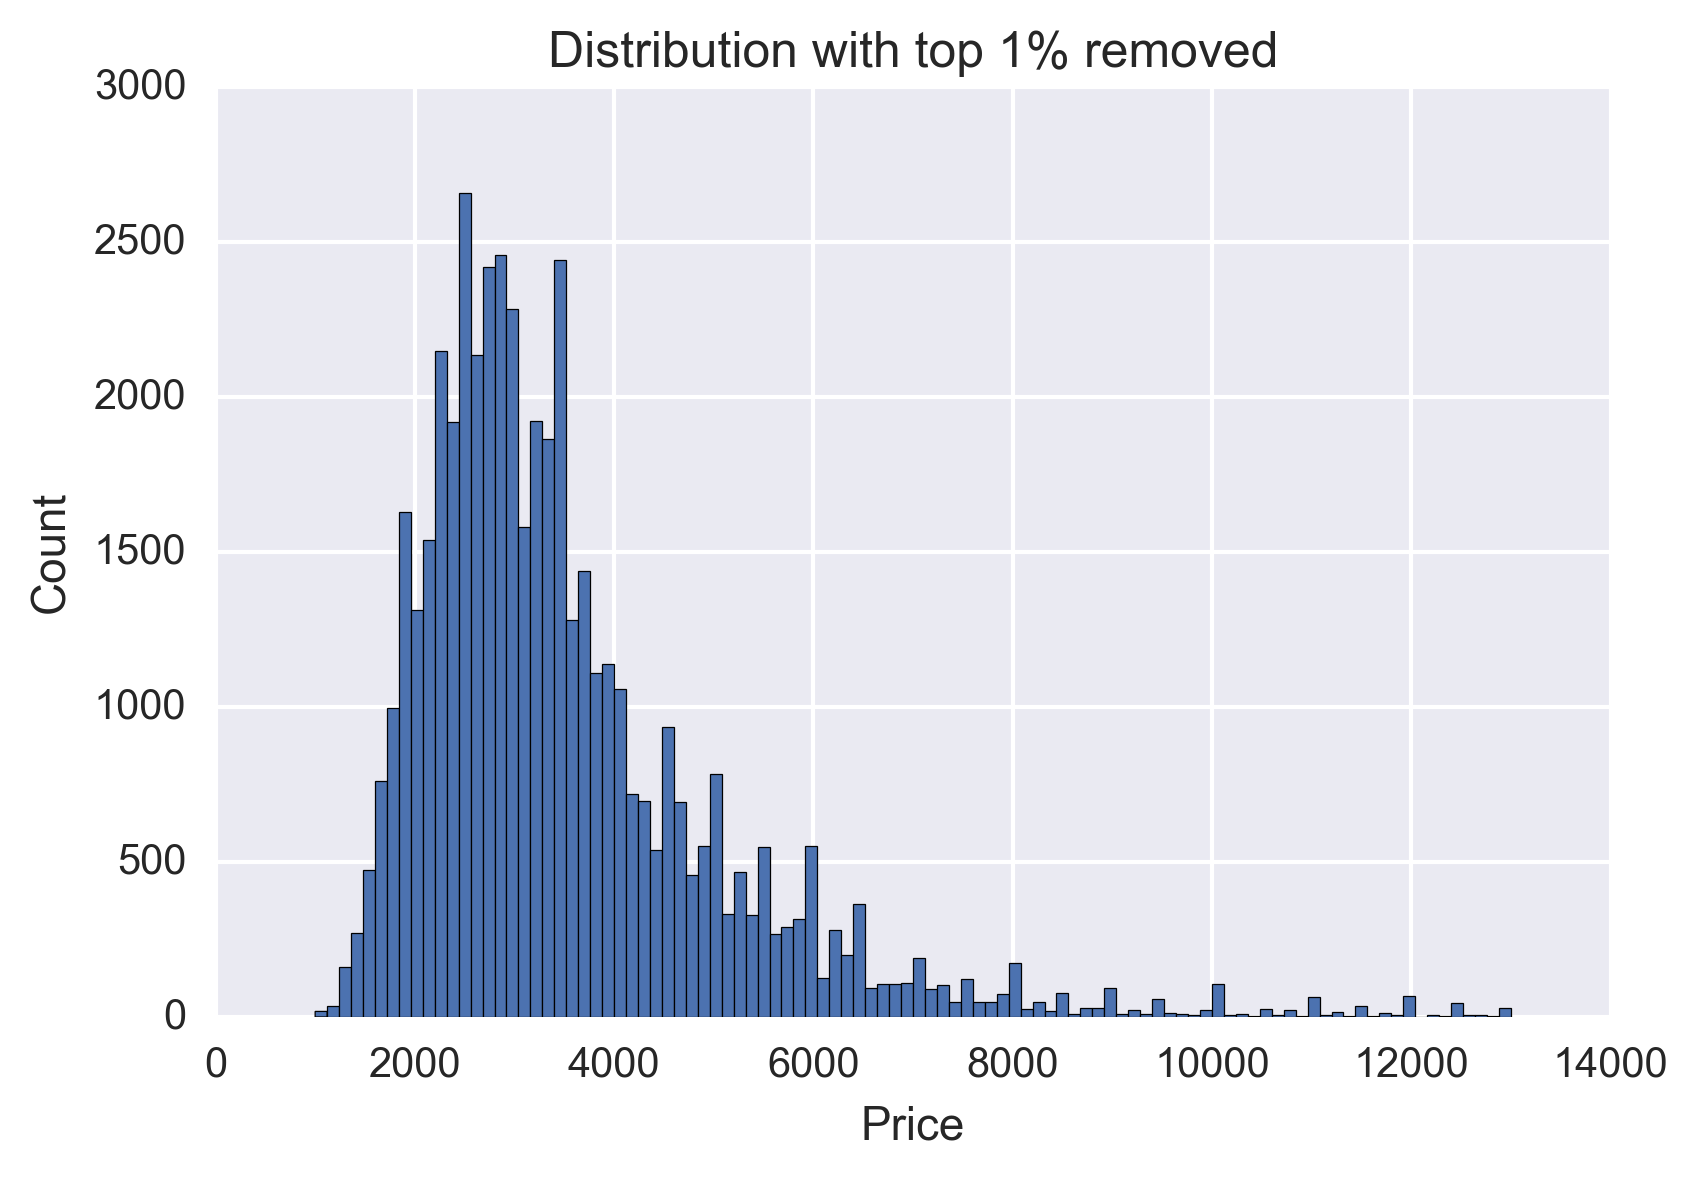

In [6]:
import matplotlib.pyplot as plt

#plt.scatter(df['longitude'], df['latitude'])
plt.hist(df['price'], 100)
plt.title("Distribution with top 1% removed")
plt.xlabel("Price")
plt.ylabel("Count")

#plt.hist(df['longitude'],50)
#plt.hist(df['longitude'],50)
plt.show()

# Feature Creation

In [7]:
# distance from borough centres
the_bronx     = [40.8448, -73.8648]
manhattan     = [40.7831, -73.9712]
queens        = [40.7282, -73.7949]
brooklyn      = [40.6782, -73.9442]
staten_island = [40.5795, -74.1502]

borough_list = {'the_bronx': the_bronx, 
                'manhattan': manhattan, 
                'queens': queens, 
                'brooklyn': brooklyn, 
                'staten_island': staten_island}

def euclid_dist(x, lat, long):
    return np.sqrt((x[0]-lat)**2 + (x[1]-long)**2)

for key in borough_list:
    df[key] = df[['latitude','longitude']].apply(euclid_dist, args=(borough_list[key]), axis=1)

### Description BoW - TO FINISH

# Exploratory Data Analysis

### EDA - Data Examples

In [8]:
df.head(3)

,bathrooms,bedrooms,building_id,description,display_address,features,interest_level,latitude,listing_id,longitude,...,photos,price,street_address,DateTime,num_of_photos,brooklyn,staten_island,the_bronx,queens,manhattan
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,...,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,2016-06-24 07:54:24,5,0.036340,0.247718,0.151708,0.148234,0.074362
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,...,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,2016-06-12 12:19:27,11,0.118653,0.282813,0.113550,0.184221,0.012442
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,...,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,2016-04-17 03:26:41,8,0.083607,0.217713,0.173220,0.207171,0.053841


### EDA - Numerical Category Summarisation

In [9]:
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price,num_of_photos,brooklyn,staten_island,the_bronx,queens,manhattan
count,48801.000000,48801.000000,48801.000000,4.880100e+04,48801.000000,48801.000000,48801.000000,48801.000000,48801.000000,48801.000000,48801.000000,48801.000000
mean,1.193459,1.524887,40.750878,7.024087e+06,-73.972417,3518.092068,5.596053,0.087457,0.248618,0.146644,0.183819,0.048990
std,0.454724,1.102438,0.039474,1.262787e+05,0.029485,1604.383201,3.623941,0.029273,0.039923,0.036411,0.025778,0.032668
min,0.000000,0.000000,40.549400,6.811957e+06,-74.094000,1000.000000,0.000000,0.002102,0.057345,0.006181,0.011951,0.000000
25%,1.000000,1.000000,40.728200,6.915987e+06,-73.991700,2495.000000,4.000000,0.071340,0.221816,0.117945,0.170478,0.023856
50%,1.000000,1.000000,40.751700,7.021026e+06,-73.977900,3125.000000,5.000000,0.084621,0.243220,0.148967,0.187008,0.039550
75%,1.000000,2.000000,40.774000,7.128751e+06,-73.954800,4034.000000,7.000000,0.099977,0.275789,0.169683,0.199418,0.063152
max,10.000000,8.000000,40.989400,7.753784e+06,-73.700100,13000.000000,68.000000,0.317122,0.493109,0.348125,0.329108,0.298071


### EDA - Column Headers

In [10]:
df.columns.tolist()

['bathrooms',
 'bedrooms',
 'building_id',
 'description',
 'display_address',
 'features',
 'interest_level',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'DateTime',
 'num_of_photos',
 'brooklyn',
 'staten_island',
 'the_bronx',
 'queens',
 'manhattan']

### EDA - general

low       33762
medium    11210
high       3829
Name: interest_level, dtype: int64


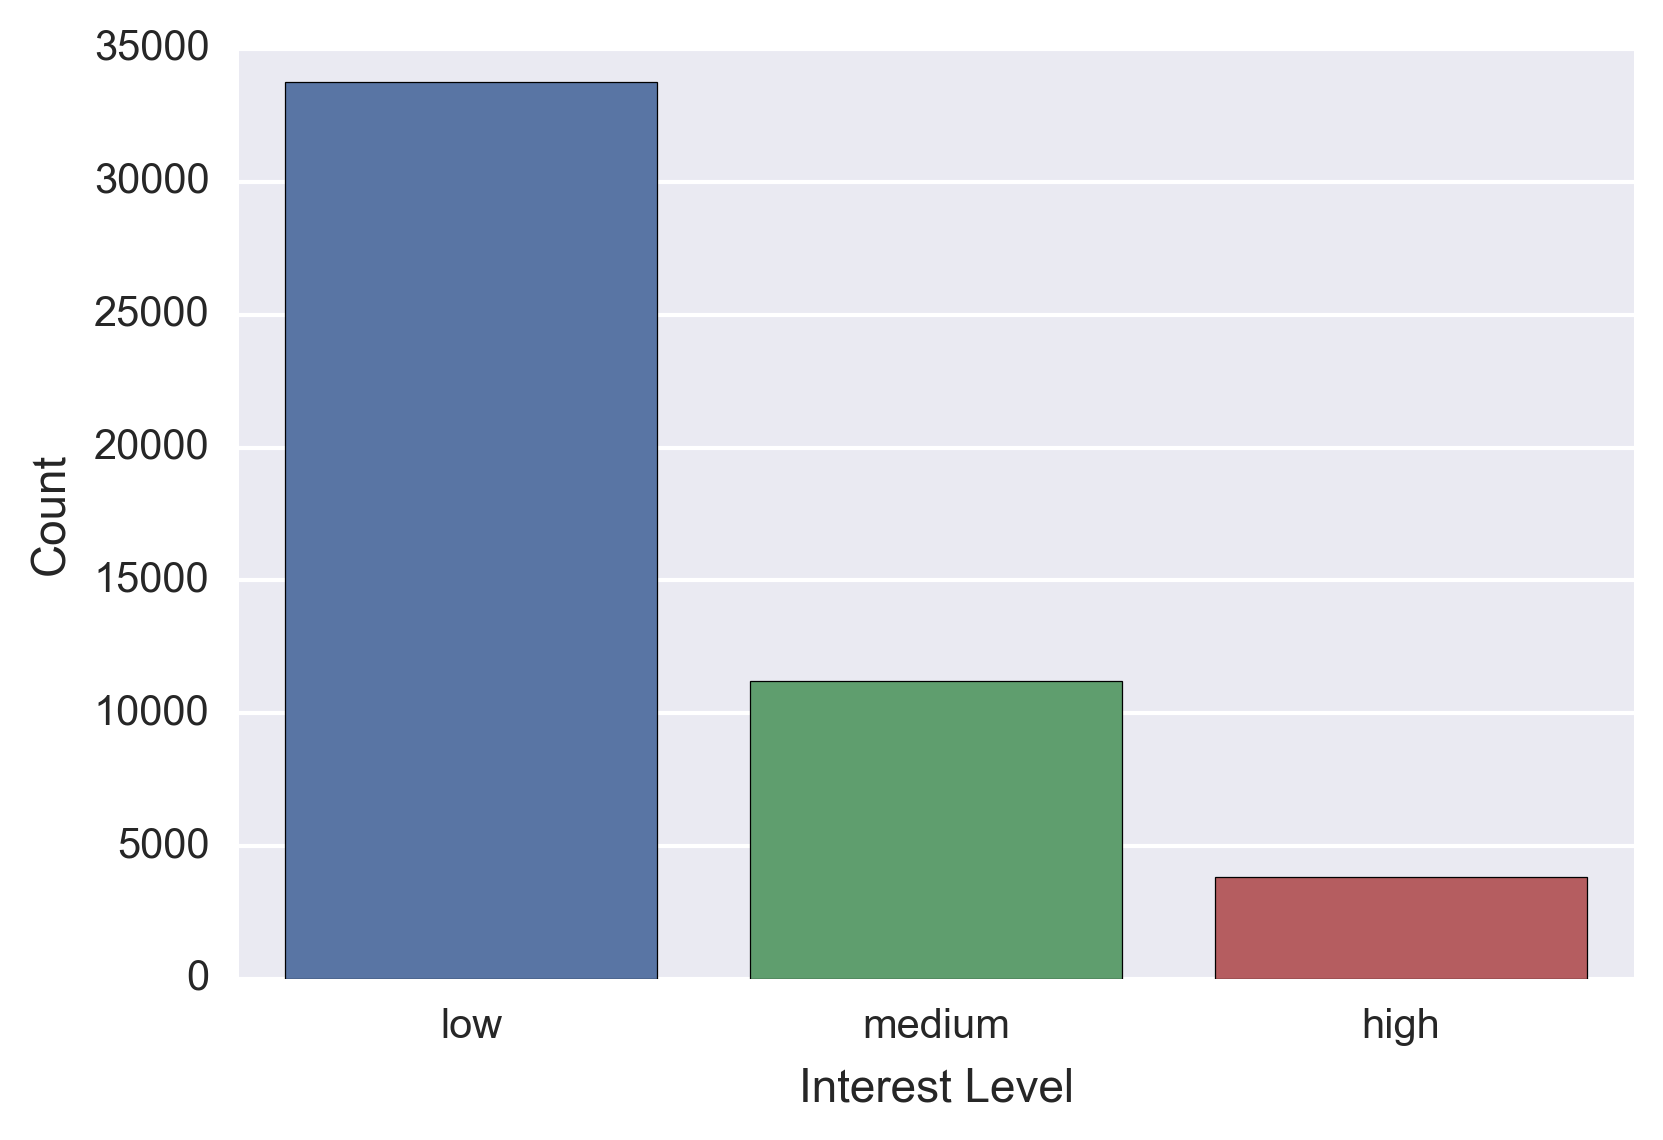

In [11]:
# plot of interest levels
interest_cat = df.interest_level.value_counts()
x = interest_cat.index
y = interest_cat.values

sns.barplot(x, y)
plt.ylabel("Count")
plt.xlabel("Interest Level")

print(df.interest_level.value_counts())

### EDA - Geospatial - MAKE MORE FANCY PLOTS WITH THIS - THIS ONE SUCKS

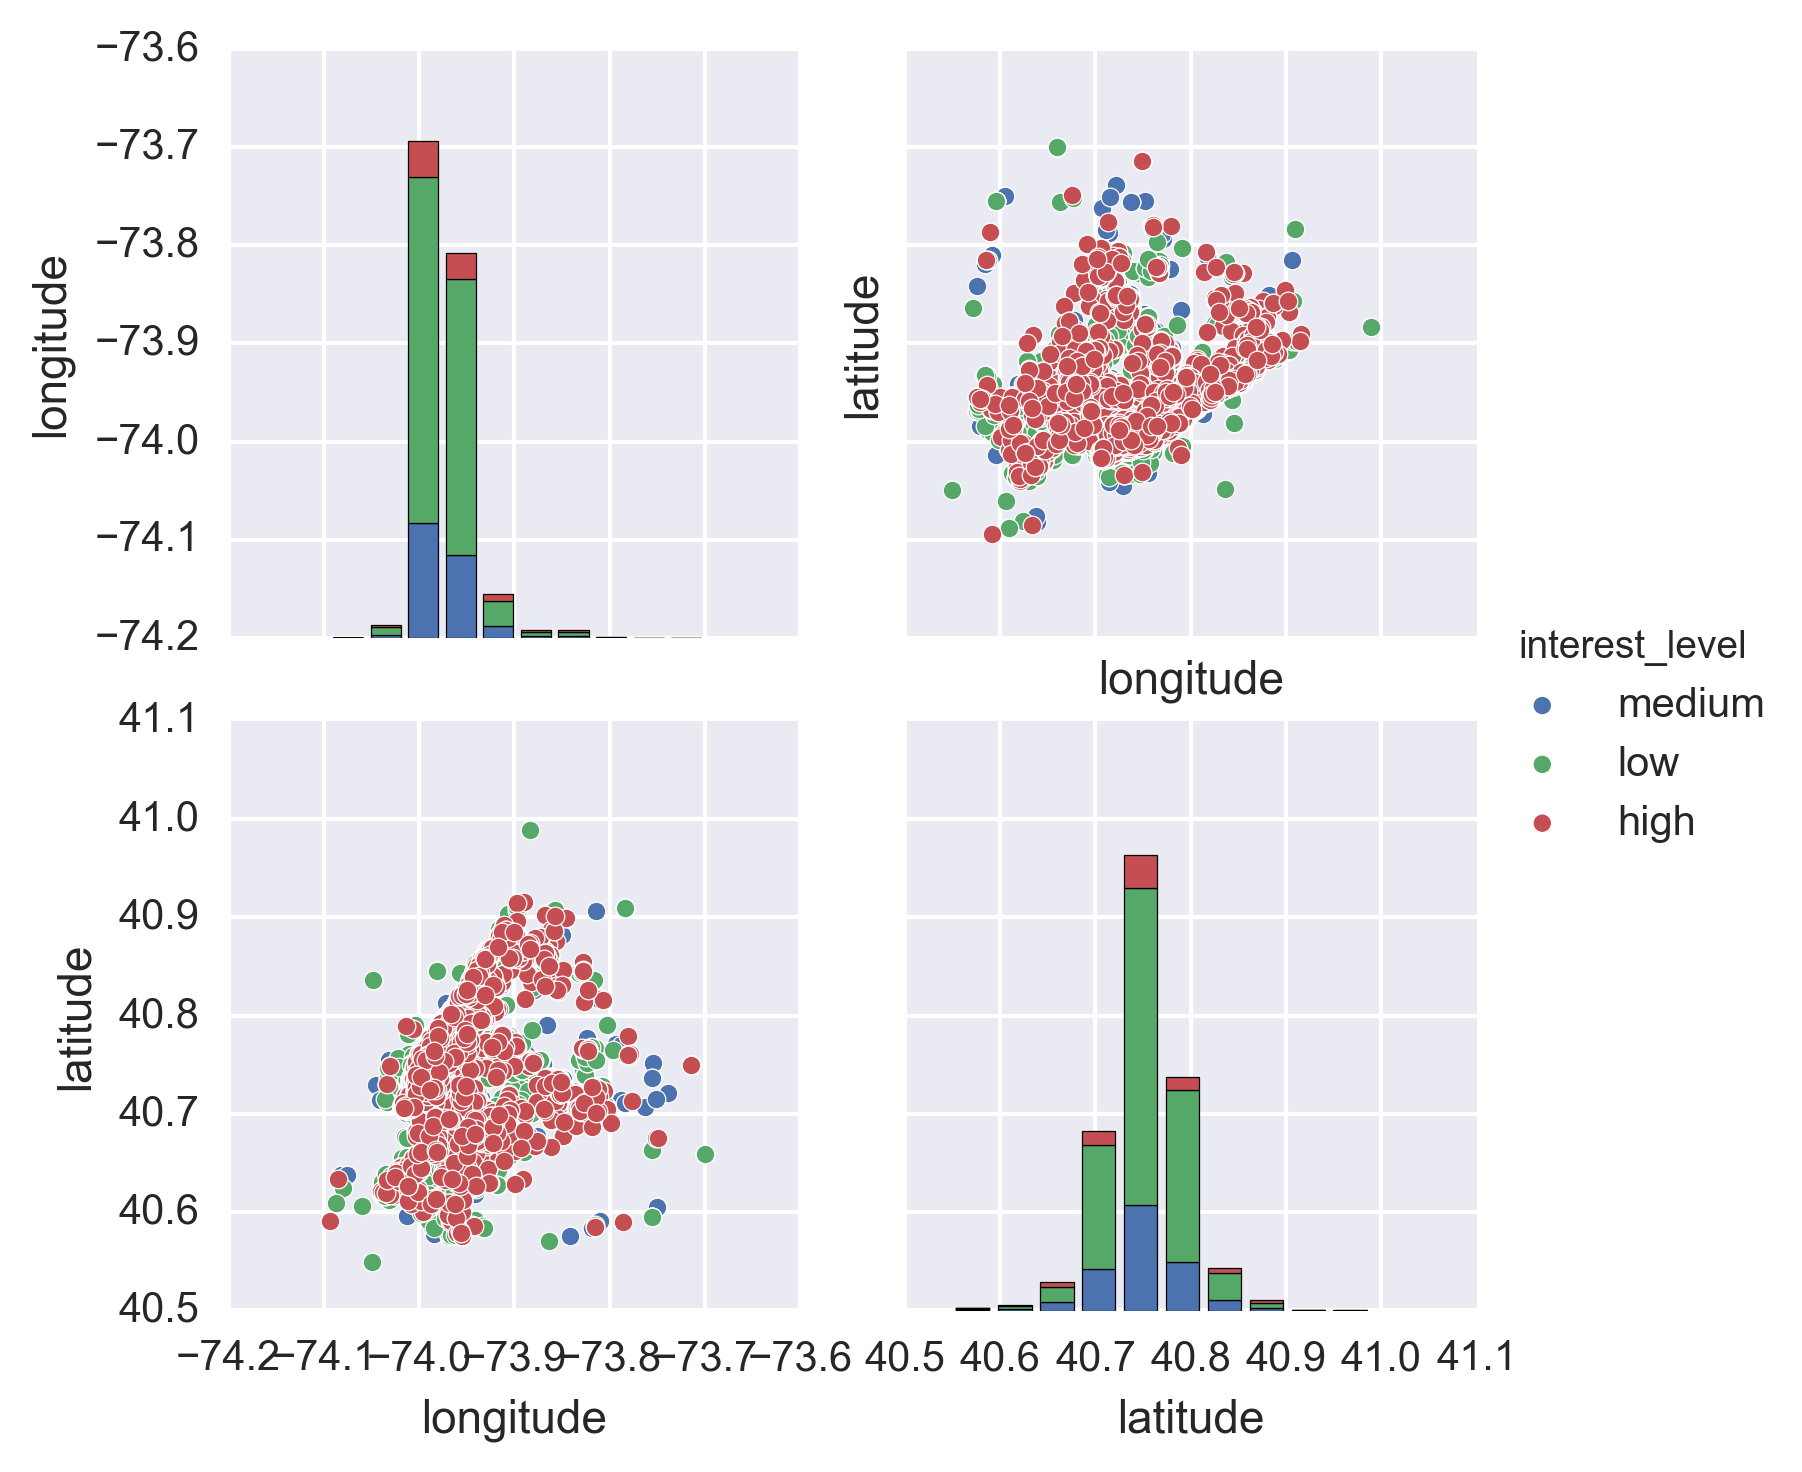

In [12]:
#position data: longitude/latitude

sns.pairplot(df[['longitude', 'latitude', 'interest_level']], hue='interest_level')
plt.ylabel('latitude')
plt.xlabel('longitude')

### EDA - bedrooms

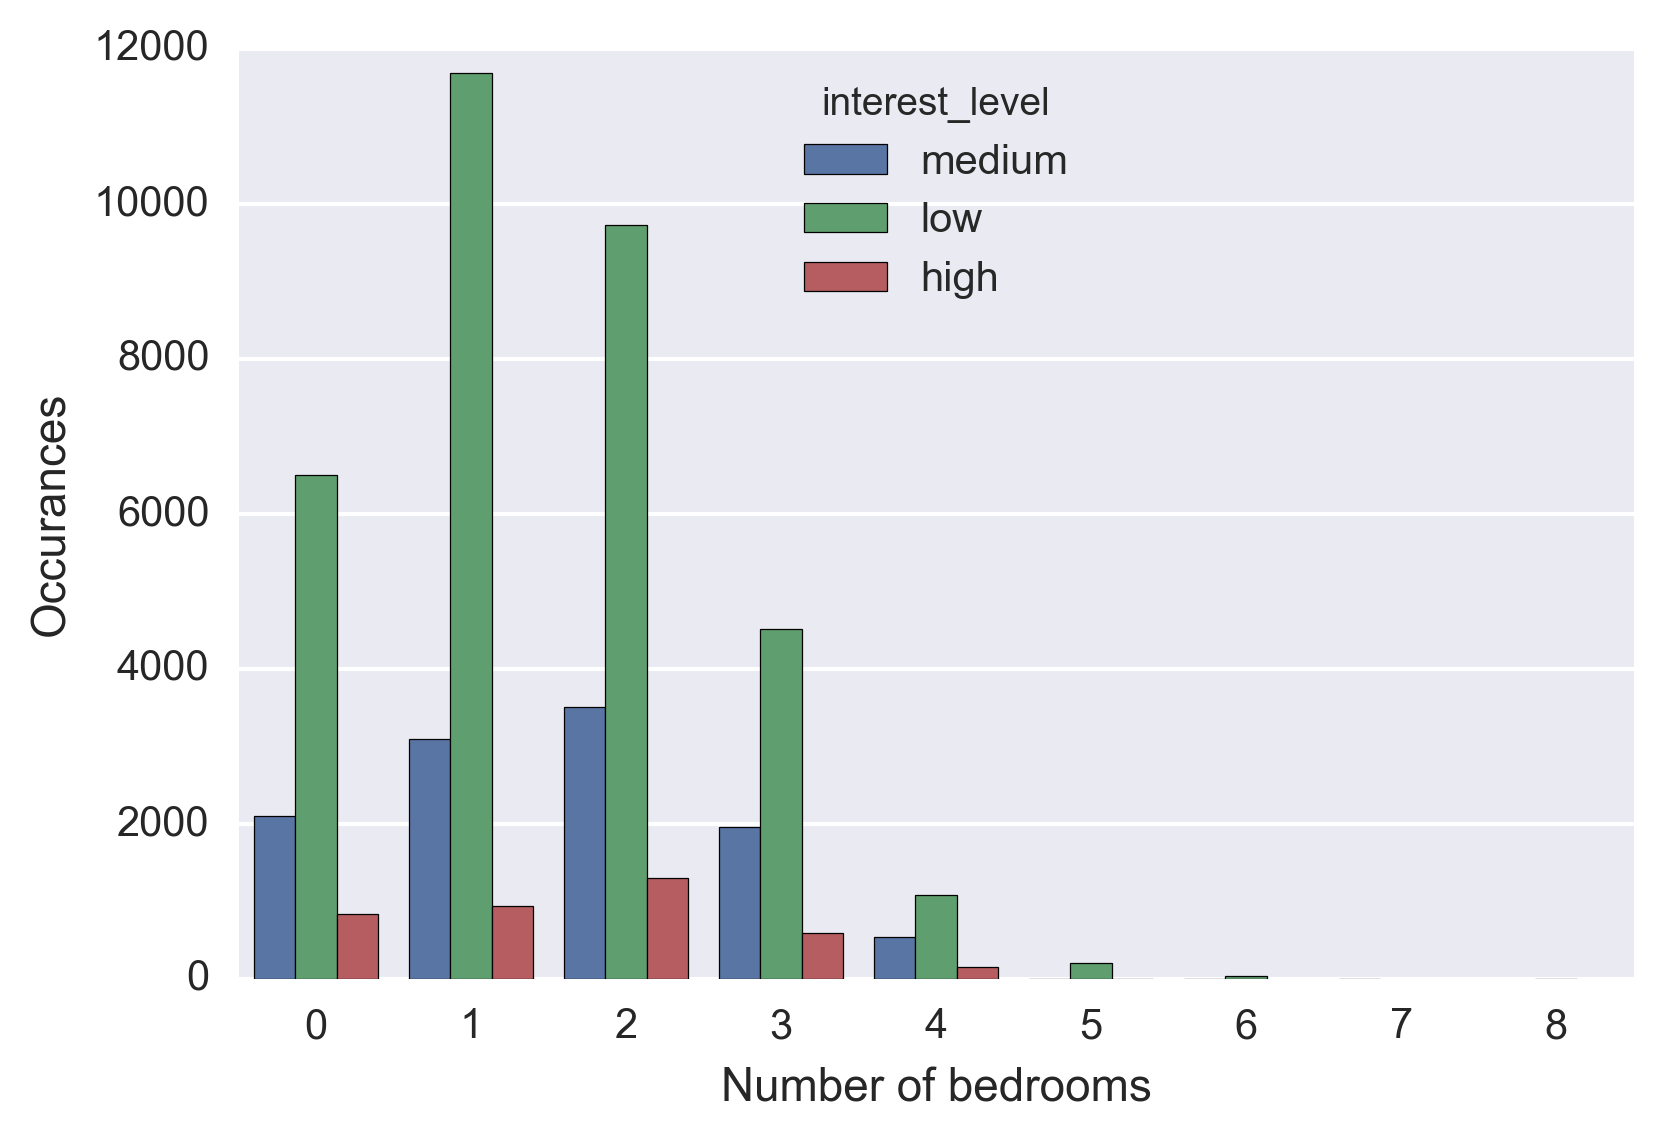

In [13]:
# bedrooms plot

sns.countplot(x='bedrooms',hue='interest_level', data=df)
plt.ylabel('Occurances')
plt.xlabel('Number of bedrooms')

### EDA - price

Mean price per interest level 
                       price
interest_level             
high            2672.380778
low             3734.592145
medium          3154.912132 

STD of price per interest level 
                       price
interest_level             
high            1111.294290
low             1708.094260
medium          1216.415636


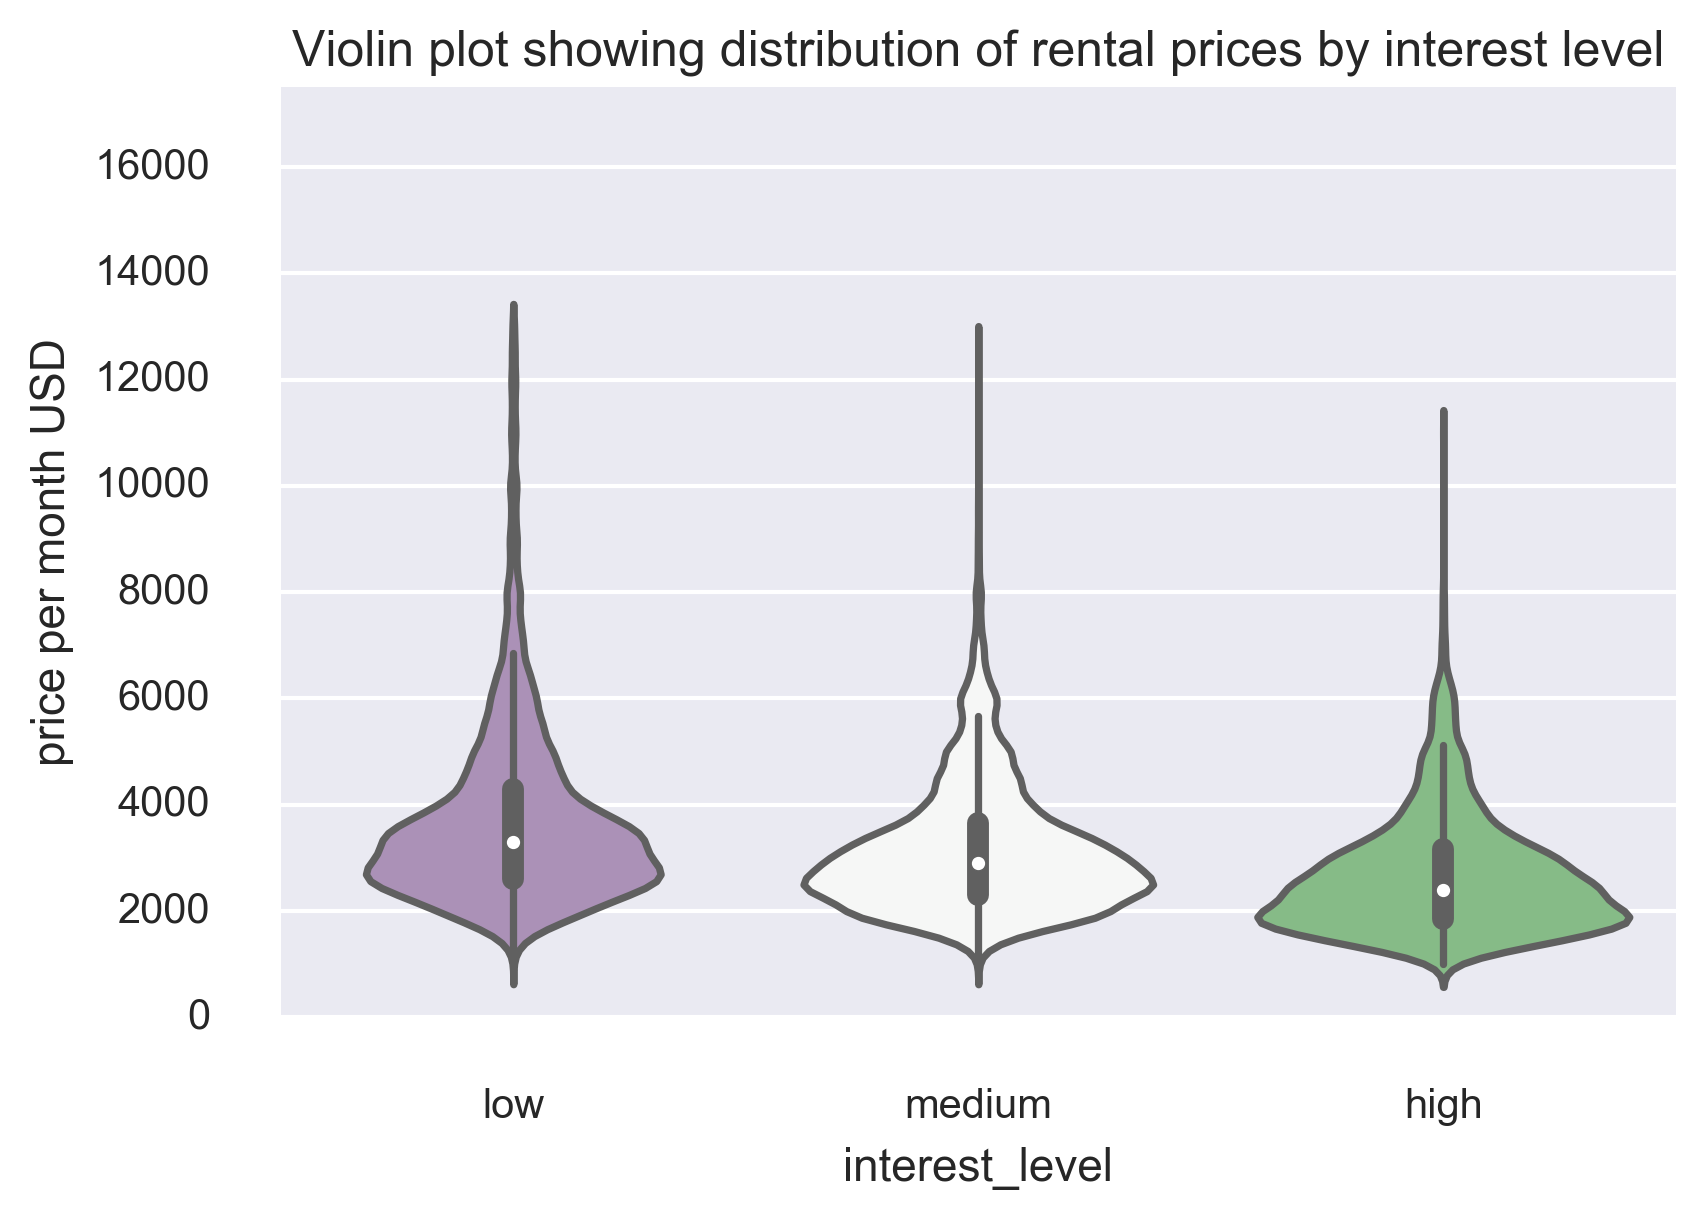

In [14]:
sns.violinplot(x="interest_level", y="price", data=df, palette="PRGn", order=['low','medium','high'])
sns.despine(offset=10, trim=True)
plt.ylabel('price per month USD')
plt.ylim(0,17500)
plt.title("Violin plot showing distribution of rental prices by interest level")

# plotting median lines
# plt.axhline(df.price[df.interest_level == 'low'].median(), linewidth = 0.25, c='purple')
# plt.axhline(df.price[df.interest_level == 'medium'].median(), linewidth = 0.25, c='black')
# plt.axhline(df.price[df.interest_level == 'high'].median(), linewidth = 0.25, c='green')

print("Mean price per interest level \n", df[['price','interest_level']].groupby('interest_level').mean(), "\n")
print("STD of price per interest level \n", df[['price','interest_level']].groupby('interest_level').std())

C:\Users\Ers\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


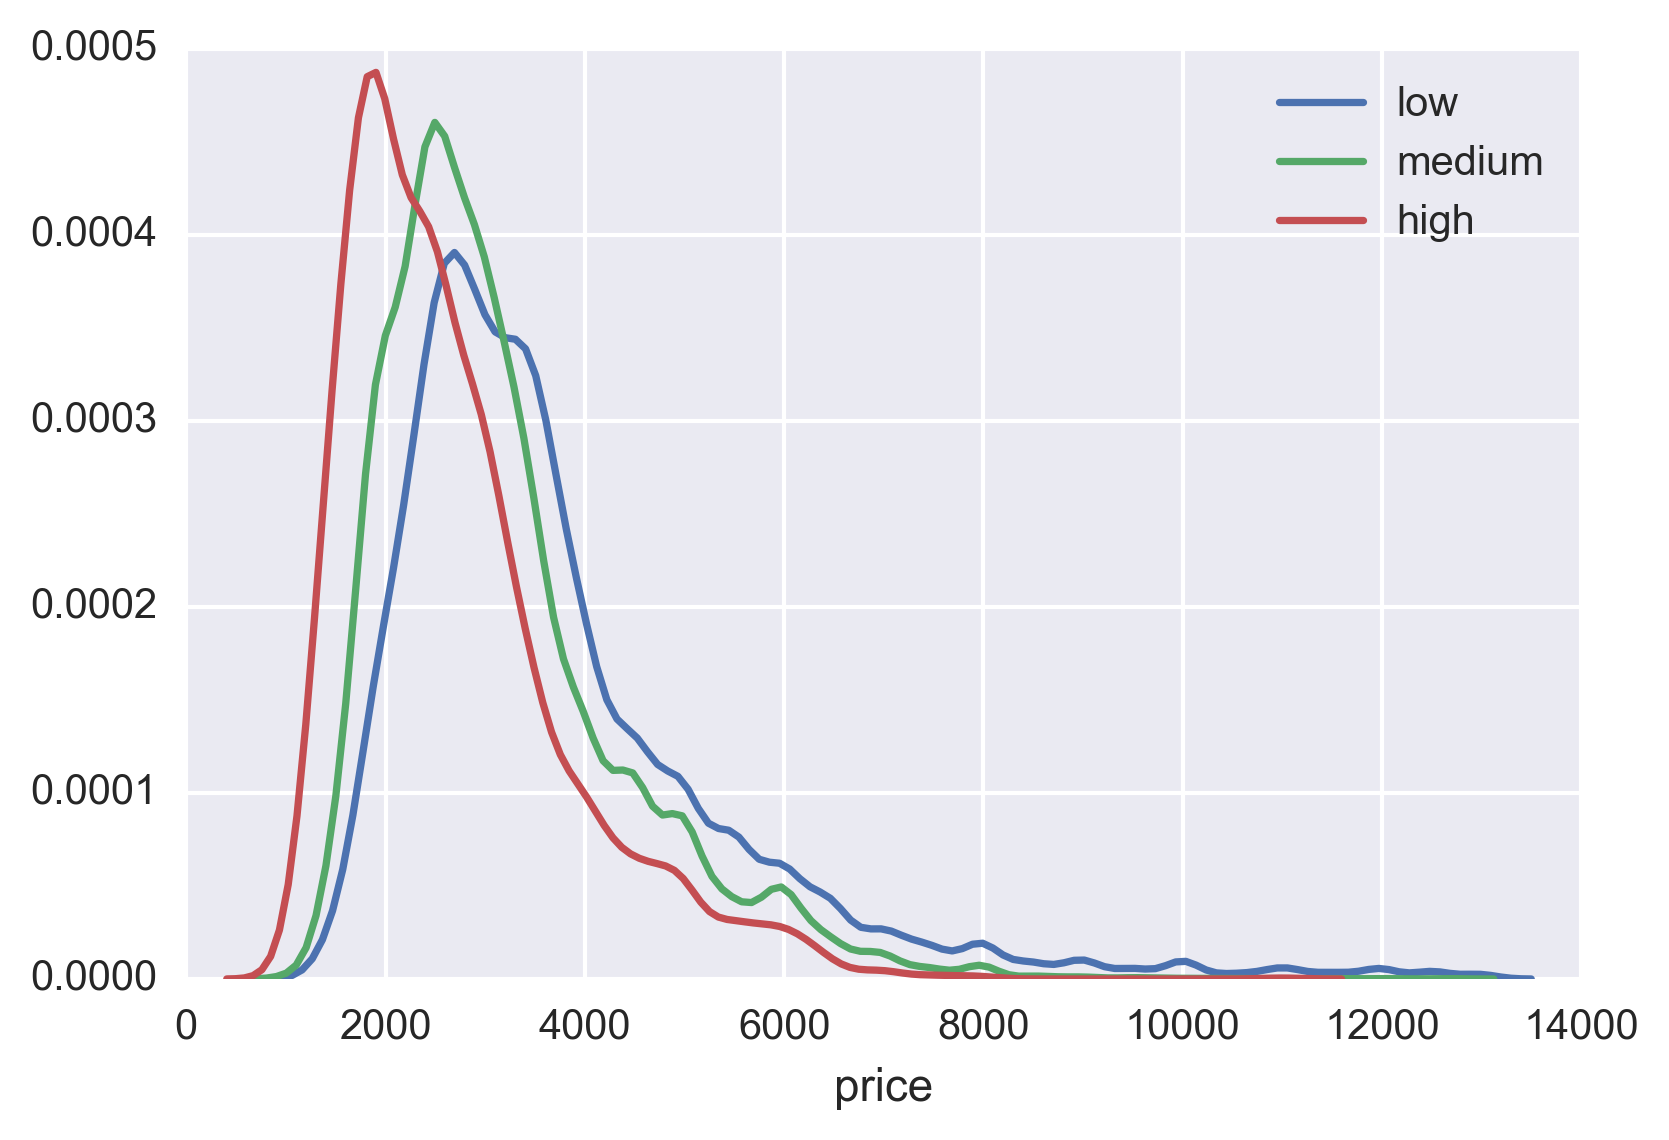

In [15]:
sns.distplot(df.price[df.interest_level == 'low'], hist=False, label='low')
sns.distplot(df.price[df.interest_level == 'medium'], hist=False, label='medium')
sns.distplot(df.price[df.interest_level == 'high'], hist=False, label='high')

# OTHER NOTES - REMOVE AT SOME POINT

In [16]:
"""
Considerations with the data:
    imbalanced dataset (not many high interest apartments compared to the rest)
    

Plots to produce
    barplot of interest levels - done
    map of interest levels
    price map
    

Features to use
    bathrooms
    bedrooms
    price

Additional features to create:
    Number of images
    description length
    creation year, month, day
    description word frequency - create features out of top x words
    distance to borough centres


Target:
    Interest Level
"""

'\nConsiderations with the data:\n    imbalanced dataset (not many high interest apartments compared to the rest)\n    \n\nPlots to produce\n    barplot of interest levels - done\n    map of interest levels\n    price map\n    \n\nFeatures to use\n    bathrooms\n    bedrooms\n    price\n\nAdditional features to create:\n    Number of images\n    description length\n    creation year, month, day\n    description word frequency - create features out of top x words\n    distance to borough centres\n\n\nTarget:\n    Interest Level\n'

# Modelling

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score as cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper

### Splitting Dataset

In [18]:
# determine features to use for modelling prior to data split
features_to_use = ['bathrooms','bedrooms','price', 'the_bronx', 'staten_island','manhattan','queens','brooklyn', 'num_of_photos']
X_all = df[features_to_use]

# convert target label into numerical (ordinal)
target_conversion = {'low':0,'medium':1,'high':2}
y_all = df.interest_level.map(target_conversion).values

X_train_val, X_test, y_train_val, y_test = train_test_split(X_all, y_all, test_size=0.1, random_state=0, stratify=y_all)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=0, stratify=y_train_val)

# mapping scaler to keep dataset in a dataframe (cannot do inverse using this function)
scaler = DataFrameMapper([(X_all.columns, StandardScaler())])
#scaler = StandardScaler()


# learn scale parameters from final training set and apply to training, val, and test sets

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


X_train_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
X_val_df = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)

# some algorithms require dummy values for multiclass classification
# target = pd.get_dummies(train.interest_level)

### Baseline Model

In [19]:
# define model params
model = RandomForestClassifier(n_estimators=100)

# train model
model.fit(X_train_scaled, y_train)

# evaluation
y_hat_train = model.predict(X_train_scaled)
y_hat_val = model.predict(X_val_scaled)


# confusion matrices - predicted class along the top, actual class down the side (low, medium, high)
print("training confusion matrix \n", confusion_matrix(y_train, y_hat_train, labels=[0,1,2]), "\n")
print("validation confusion matrix \n", confusion_matrix(y_val, y_hat_val, labels=[0,1,2]), "\n")

y_hat_train = model.predict_proba(X_train_scaled)
y_hat_val = model.predict_proba(X_val_scaled)

# log loss evaluations for train, val
print("log loss - training:", log_loss(y_train, y_hat_train))
print("log loss - validation:", log_loss(y_val, y_hat_val))

training confusion matrix 
 [[26847   439    61]
 [  801  8149   130]
 [  128   253  2720]] 

validation confusion matrix 
 [[2638  338   62]
 [ 582  327  100]
 [ 118  126  101]] 

log loss - training: 0.191840573346
log loss - validation: 1.03722436836


# Modelling TODO

In [20]:
# feature importance measures

#from sklearn.ensemble import ExtraTreesClassifier
#clf = ExtraTreesClassifier()
#clf = clf.fit(features, target)
#clf.feature_importances_

NameError: name 'features' is not defined